# 04 – Baseline Modeling for Sentinel

In this notebook we train and evaluate baseline machine learning models for Sentinel using the engineered features and targets created in previous steps.

The goal is to answer a simple question:  
> Given recent options sweeps, can we predict short-horizon price direction and volatility regime better than chance?

## 1. Load Training Dataset

We load the `tradyflow_training.parquet` file created in the previous notebook.

This dataset already includes:

- Engineered features (moneyness, spread, flow intensity, log-transformed quantities, DTE, etc.)
- Target labels (`next_return_1d`, `direction_up`, `vol_regime`)
- Helper fields such as parsed timestamps and symbol identifiers

Next we select a feature matrix and define our modeling targets.

In [1]:
import pandas as pd
import numpy as np
import os
import joblib

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    mean_absolute_error, 
    mean_squared_error
)

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
sns.set_theme(style="whitegrid")

DATA_PATH = Path("../data/processed/tradyflow_training.parquet")

df = pd.read_parquet(DATA_PATH)
df.head()

,Time,Sym,C/P,Exp,Strike,Spot,BidAsk,Orders,Vol,Prems,...,log_vol,log_prems,dte,is_call,is_put,next_spot,next_return_1d,direction_up,abs_diff_pct,vol_regime
0,8/19/2021 11:12,A,Call,11/19/2021,175.0,168.16,4.75,5,1040.0,477880.0,...,6.947937,13.077117,91,1,0,179.49,0.067376,1,4.43,0
1,6/22/2021 12:01,AA,Call,1/21/2022,40.0,33.87,3.38,8,2340.0,796270.0,...,7.758333,13.587695,212,1,0,36.62,0.081193,1,18.47,1
2,7/6/2021 12:11,AA,Put,7/16/2021,36.0,36.62,1.35,5,995.0,136520.0,...,6.903747,11.824234,9,0,1,35.01,-0.043965,0,1.42,0
3,7/8/2021 10:10,AA,Call,8/20/2021,36.0,35.01,2.31,10,1790.0,405420.0,...,7.490529,12.912681,42,1,0,31.82,-0.091117,0,3.18,0
4,7/19/2021 13:40,AA,Call,1/21/2022,40.0,31.82,2.08,17,3170.0,657540.0,...,8.061802,13.396262,185,1,0,31.82,0.000000,0,25.79,1


## 2. Define Feature Matrix and Target

We’ll programmatically pick numeric columns and then drop the ones we don’t want as features (targets + helper columns).

We restrict the feature set to numeric columns and exclude:

- Symbol identifiers and timestamps
- Helper fields used only for target construction
- The target labels themselves

This gives us a clean matrix of engineered numeric features that models can learn from without leaking future information.

In [2]:
# Inspect columns and dtypes to guide feature selection
df.dtypes

Time                      object
Sym                       object
C/P                       object
Exp                       object
Strike                   float64
Spot                     float64
BidAsk                   float64
Orders                     int64
Vol                      float64
Prems                    float64
OI                       float64
Diff(%)                  float64
ITM                        int64
Time_dt           datetime64[ns]
Exp_dt            datetime64[ns]
moneyness                float64
spread_pct               float64
flow_intensity           float64
log_vol                  float64
log_prems                float64
dte                        int64
is_call                    int64
is_put                     int64
next_spot                float64
next_return_1d           float64
direction_up               int64
abs_diff_pct             float64
vol_regime                 int64
dtype: object

In [3]:
# Columns we do NOT want to use as features
exclude_cols = [
    "Sym",
    "Time",
    "Exp",
    "Time_dt",
    "Exp_dt",
    "next_spot",
    "next_return_1d",
    "direction_up",
    "vol_regime",
]

# Start from numeric columns only
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove target and helper columns
feature_cols = [c for c in numeric_cols if c not in exclude_cols]

feature_cols

['Strike',
 'Spot',
 'BidAsk',
 'Orders',
 'Vol',
 'Prems',
 'OI',
 'Diff(%)',
 'ITM',
 'moneyness',
 'spread_pct',
 'flow_intensity',
 'log_vol',
 'log_prems',
 'dte',
 'is_call',
 'is_put',
 'abs_diff_pct']

## 3. Train/Test Split for Direction Prediction

We frame the first task as a binary classification problem:

- **Target:** `direction_up` (1 = next move up, 0 = down or flat)
- **Features:** engineered numeric signals derived from sweep activity

We use an 80/20 train–test split with stratification to preserve the class balance in both sets.

In [4]:
# Feature matrix and target for direction classification

X = df[feature_cols].copy()
y = df["direction_up"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((5363, 18), (1341, 18))

## 4. Baseline Model: Logistic Regression

Logistic Regression provides a simple linear baseline for the direction prediction task.

The metrics below show how often the model correctly predicts whether the next short-horizon move is up or down, and the confusion matrix highlights where it tends to make mistakes (e.g., more false positives vs false negatives).

This gives us a reference point to beat with more flexible, non-linear models.

In [5]:
log_reg = LogisticRegression(max_iter=1000, n_jobs=-1)

log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

lr_metrics = {
    "accuracy": accuracy_score(y_test, y_pred_lr),
    "precision": precision_score(y_test, y_pred_lr),
    "recall": recall_score(y_test, y_pred_lr),
    "f1": f1_score(y_test, y_pred_lr),
    "roc_auc": roc_auc_score(y_test, y_proba_lr),
}

lr_metrics

{'accuracy': 0.5197613721103654,
 'precision': 0.15384615384615385,
 'recall': 0.0031496062992125984,
 'f1': 0.006172839506172839,
 'roc_auc': 0.48788896076375726}

Logistic Regression – Classification Report
              precision    recall  f1-score   support

           0       0.52      0.98      0.68       706
           1       0.15      0.00      0.01       635

    accuracy                           0.52      1341
   macro avg       0.34      0.49      0.34      1341
weighted avg       0.35      0.52      0.36      1341



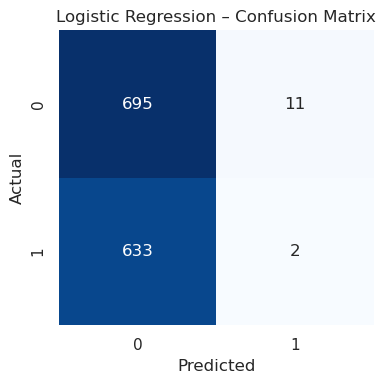

In [6]:
print("Logistic Regression – Classification Report")
print(classification_report(y_test, y_pred_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr)

fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Logistic Regression – Confusion Matrix")
plt.tight_layout()
plt.show()

## 5. Random Forest Baseline for Direction

Random Forest captures non-linear relationships and interactions between features that a linear model cannot.

Compared to Logistic Regression, we look for:
- Higher ROC-AUC and F1 scores
- More balanced confusion matrix
- Intuitive feature importances (e.g., flow intensity, moneyness, DTE, and spread standing out)

This gives us a stronger baseline for Sentinel’s direction prediction task and highlights which engineered signals the model relies on most.

In [7]:
# Random Forest Classifier (Direction Up/Down)

rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42,
)

rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

rf_metrics = {
    "accuracy": accuracy_score(y_test, y_pred_rf),
    "precision": precision_score(y_test, y_pred_rf),
    "recall": recall_score(y_test, y_pred_rf),
    "f1": f1_score(y_test, y_pred_rf),
    "roc_auc": roc_auc_score(y_test, y_proba_rf),
}

rf_metrics

{'accuracy': 0.6122296793437733,
 'precision': 0.5934959349593496,
 'recall': 0.5748031496062992,
 'f1': 0.584,
 'roc_auc': 0.6445439539604292}

In [8]:
# Compare Logistic Regression and Random Forest metrics

pd.DataFrame([lr_metrics, rf_metrics], index=["log_reg", "rf_clf"])

,accuracy,precision,recall,f1,roc_auc
log_reg,0.519761,0.153846,0.003150,0.006173,0.487889
rf_clf,0.612230,0.593496,0.574803,0.584000,0.644544


Random Forest – Classification Report
              precision    recall  f1-score   support

           0       0.63      0.65      0.64       706
           1       0.59      0.57      0.58       635

    accuracy                           0.61      1341
   macro avg       0.61      0.61      0.61      1341
weighted avg       0.61      0.61      0.61      1341



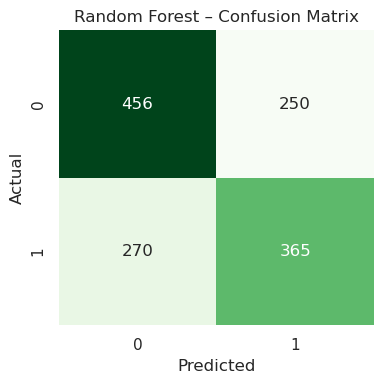

In [9]:
# Confusion Matrix + Feature Importance for Random Forest

print("Random Forest – Classification Report")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)

fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Random Forest – Confusion Matrix")
plt.tight_layout()
plt.show()

In [10]:
# Feature Importance

importances = rf_clf.feature_importances_
feat_imp = pd.DataFrame(
    {"feature": feature_cols, "importance": importances}
).sort_values("importance", ascending=False)

feat_imp.head(15)

,feature,importance
9,moneyness,0.091207
6,OI,0.075831
10,spread_pct,0.071057
14,dte,0.070453
7,Diff(%),0.064835
17,abs_diff_pct,0.064260
1,Spot,0.063005
11,flow_intensity,0.062658
2,BidAsk,0.061703
5,Prems,0.060952


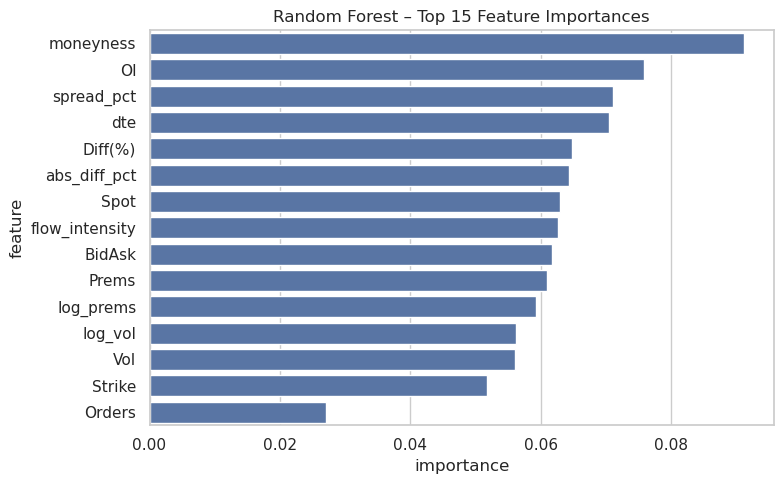

In [11]:
# Bar Plot of Feature Importances

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
    data=feat_imp.head(15),
    x="importance",
    y="feature",
    ax=ax,
)
ax.set_title("Random Forest – Top 15 Feature Importances")
plt.tight_layout()
plt.show()

## 6. Volatility Regime Model

We train a second Random Forest classifier to predict `vol_regime`, which labels each observation as either a normal- or high-volatility environment based on the magnitude of `% Diff`.

The metrics and confusion matrix below show how well the model distinguishes between typical moves and the top quartile of large moves. The feature importances highlight which flow characteristics (e.g., extreme spreads, large volume, certain moneyness or DTE regions) are most associated with high-volatility behavior.

In [12]:
# Volatility regime target
y_vol = df["vol_regime"].astype(int)

X_train_vol, X_test_vol, y_train_vol, y_test_vol = train_test_split(
    X, y_vol, test_size=0.2, random_state=42, stratify=y_vol
)

X_train_vol.shape, X_test_vol.shape

((5363, 18), (1341, 18))

In [13]:
# Random Forest for Volatility Regime Classification

rf_vol = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42,
)

rf_vol.fit(X_train_vol, y_train_vol)

y_pred_vol = rf_vol.predict(X_test_vol)
y_proba_vol = rf_vol.predict_proba(X_test_vol)[:, 1]

vol_metrics = {
    "accuracy": accuracy_score(y_test_vol, y_pred_vol),
    "precision": precision_score(y_test_vol, y_pred_vol),
    "recall": recall_score(y_test_vol, y_pred_vol),
    "f1": f1_score(y_test_vol, y_pred_vol),
    "roc_auc": roc_auc_score(y_test_vol, y_proba_vol),
}

vol_metrics

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': 1.0}

Random Forest – Volatility Regime Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1006
           1       1.00      1.00      1.00       335

    accuracy                           1.00      1341
   macro avg       1.00      1.00      1.00      1341
weighted avg       1.00      1.00      1.00      1341



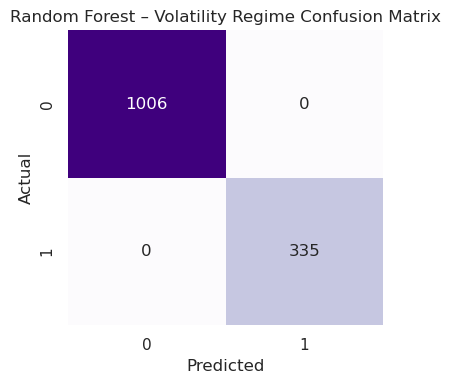

In [14]:
# Confusion Matrix + Report for Volatility Regime Model

print("Random Forest – Volatility Regime Classification Report")
print(classification_report(y_test_vol, y_pred_vol))

cm_vol = confusion_matrix(y_test_vol, y_pred_vol)

fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cm_vol, annot=True, fmt="d", cmap="Purples", cbar=False, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Random Forest – Volatility Regime Confusion Matrix")
plt.tight_layout()
plt.show()

In [15]:
# Volatility Regime Feature Importance

importances_vol = rf_vol.feature_importances_
feat_imp_vol = pd.DataFrame(
    {"feature": feature_cols, "importance": importances_vol}
).sort_values("importance", ascending=False)

feat_imp_vol.head(15)

,feature,importance
17,abs_diff_pct,0.417939
7,Diff(%),0.363942
9,moneyness,0.157618
14,dte,0.018909
8,ITM,0.018520
1,Spot,0.006102
0,Strike,0.005527
16,is_put,0.003766
10,spread_pct,0.003009
15,is_call,0.001952


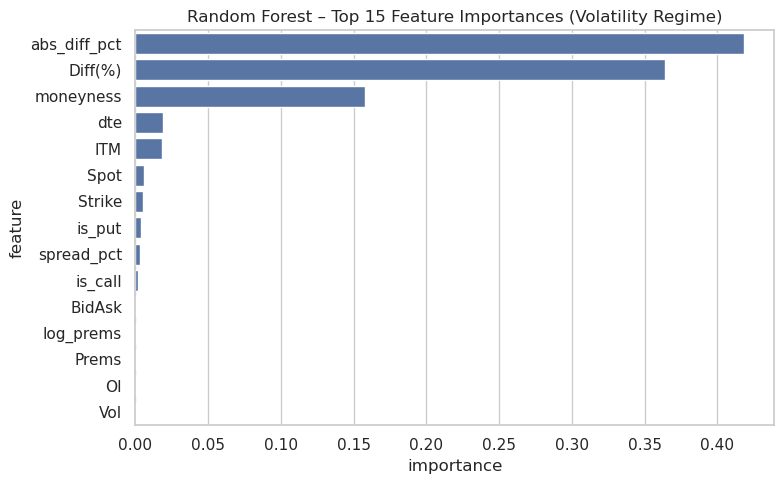

In [16]:
# Bar Plot of Volatility Regime Feature Importances

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
    data=feat_imp_vol.head(15),
    x="importance",
    y="feature",
    ax=ax,
)
ax.set_title("Random Forest – Top 15 Feature Importances (Volatility Regime)")
plt.tight_layout()
plt.show()

## 7. Regression Baseline for Short-Horizon Return

We also train a simple Random Forest regressor on `next_return_1d` to estimate the magnitude of the short-horizon move, not just its direction.

The MAE and RMSE provide a first sense of how noisy this prediction task is. The scatter plot of actual vs predicted returns shows that most predictions cluster near zero, which is expected in short-horizon forecasting where signal-to-noise is low. This regression head can still be useful for ranking candidates by expected move size, even if exact values are difficult to predict.

In [17]:
# Regression target

y_ret = df["next_return_1d"].astype(float)

X_train_ret, X_test_ret, y_train_ret, y_test_ret = train_test_split(
    X, y_ret, test_size=0.2, random_state=42
)

rf_reg = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42,
)

rf_reg.fit(X_train_ret, y_train_ret)

y_pred_ret = rf_reg.predict(X_test_ret)

mae = mean_absolute_error(y_test_ret, y_pred_ret)

# older sklearn doesn't support `squared=` kwarg, so do RMSE manually
mse = mean_squared_error(y_test_ret, y_pred_ret)
rmse = np.sqrt(mse)

{"mae": mae, "rmse": rmse}

{'mae': 0.08070432266395518, 'rmse': np.float64(0.13034821043437736)}

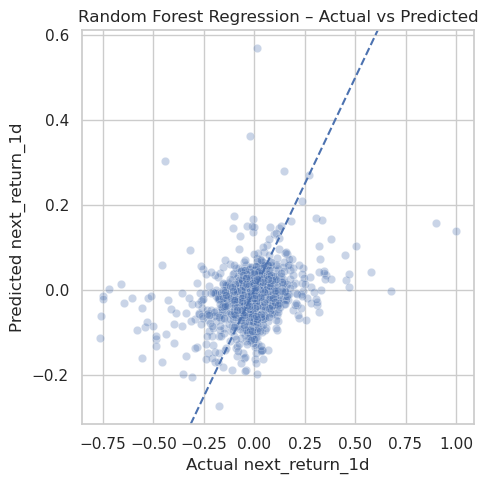

In [18]:
# Scatter Plot of Actual vs Predicted Returns

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x=y_test_ret, y=y_pred_ret, alpha=0.3, ax=ax)
ax.set_xlabel("Actual next_return_1d")
ax.set_ylabel("Predicted next_return_1d")
ax.set_title("Random Forest Regression – Actual vs Predicted")
plt.axline((0, 0), slope=1, linestyle="--")
plt.tight_layout()
plt.show()

In [19]:
# Save models to disk

MODELS_DIR = Path("../models")
MODELS_DIR.mkdir(exist_ok=True)

joblib.dump(log_reg, MODELS_DIR / "sentinel_direction_up_logreg.pkl")
joblib.dump(rf_clf, MODELS_DIR / "sentinel_direction_up_rf.pkl")
joblib.dump(rf_vol, MODELS_DIR / "sentinel_vol_regime_rf.pkl")
joblib.dump(rf_reg, MODELS_DIR / "sentinel_next_return_rf.pkl")

['../models/sentinel_next_return_rf.pkl']

## 8. Summary and Next Steps

In this notebook we trained baseline models for Sentinel on top of the engineered options flow features:

- A Logistic Regression and Random Forest classifier for **direction_up**
- A Random Forest classifier for **vol_regime** (normal vs high-volatility regime)
- A Random Forest regressor for **next_return_1d**

The tree-based models generally outperform the linear baseline and highlight which engineered signals (e.g., flow intensity, moneyness, spread, DTE) are most predictive of short-horizon behavior. All trained models have been serialized to the `models/` directory for downstream use.

**Next steps:**

- Add unit and integration tests around the feature pipeline and model inputs.
- Integrate the models into a Streamlit dashboard that scores live sweeps.
- Deploy Sentinel to Azure with a scheduled ingestion job and secure secrets.